In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ys19-2023-assignment-3/sample_submission.csv
/kaggle/input/ys19-2023-assignment-3/test_set.csv
/kaggle/input/ys19-2023-assignment-3/valid_set.csv
/kaggle/input/ys19-2023-assignment-3/train_set.csv


In [2]:
# spaCy for Greek language handling
!python -m spacy download el_core_news_md
# pandarallel for faster applying of functions to dataframes. Need for tokens, lemmas etc.
!pip install unidecode
!pip install pandarallel
!pip install torch
!pip install gensim

print("\n")
print("INSTALLATIONS COMPLETE.")

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 42.9/42.9 MB 22.1 MB/s eta 0:00:00
‚úî Download and installation successful
You can now load the package via spacy.load('el_core_news_md')
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=1c19f4311846dc2def491cbdb7ffd3ca9adb7e251924d9e3ff42cb8c0db6cfec
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


INSTALLATIONS COMPLETE.


## Imports

In [3]:
import spacy
from pandarallel import pandarallel
from sklearn.linear_model import LogisticRegression
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score,roc_curve
from matplotlib import pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import unicodedata as ud
from unidecode import unidecode
from sklearn.model_selection import GridSearchCV
import optuna
from scipy.sparse import hstack
import nltk
import random
from torch.nn.utils import clip_grad_norm_

# HW2 new imports
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.nn.functional as F

print('Imports done.')

Imports done.


## Data preprocessing

In [4]:
nlp = spacy.load('el_core_news_md')
df = pd.read_csv('/kaggle/input/ys19-2023-assignment-3/train_set.csv')
valid_df = pd.read_csv('/kaggle/input/ys19-2023-assignment-3/valid_set.csv')
test_df = pd.read_csv('/kaggle/input/ys19-2023-assignment-3/test_set.csv')

df.head()

New_ID                                               Text Sentiment   Party
0   35027  #Œ±œÄŒøŒªœÖŒºŒ±ŒΩœÉŒ∑_Œ∫ŒøœÅŒπŒøŒπ #Œ±œÄŒµŒΩœÑŒøŒºœâœÉŒ∑_Œ∫ŒøœÅŒπŒøœÇ #Œ±œÄŒøŒªœÖŒºŒ±...   NEUTRAL  SYRIZA
1    9531  ŒàŒæŒπ ŒΩŒ≠ŒµœÇ ŒµœÄŒπœÉœÑŒøŒªŒ≠œÇ Œ≥ŒπŒ± œÑŒ∑ ŒúŒ±Œ∫ŒµŒ¥ŒøŒΩŒØŒ± ¬´Œ∫Œ±ŒØŒΩŒµ¬ª œÑŒ∑...  NEGATIVE      ND
2   14146  ŒôœÉœáœÖœÅœå ŒöŒöŒï, Œ¥œçŒΩŒ±ŒºŒ∑ œÑŒøœÖ ŒªŒ±Œøœç œÉœÑŒ∑ ŒíŒøœÖŒªŒÆ Œ∫Œ±Œπ œÉœÑŒøœÖ...  POSITIVE     KKE
3   28716  @five2nds @anthi7vas ŒúŒΩŒ∑ŒºŒøŒΩŒπŒ±Œ∫œåœÑŒ±œÑŒø œÑŒø #ŒúŒµŒ°Œë25...   NEUTRAL     KKE
4   32886  @ai_katerina ŒëœÖœÑœå œÄŒøœÖ ŒµŒØŒΩŒ±Œπ œÉœÖŒ≥Œ∫ŒªŒøŒΩŒπœÉœÑŒπŒ∫œå ŒµŒØŒΩŒ±...   NEUTRAL  SYRIZA

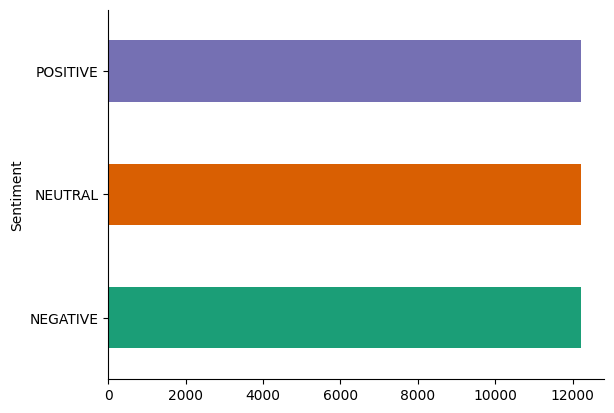

In [5]:
# Visualize our data (specifically the Sentiment column)
# Data Distribution

df.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

<Axes: xlabel='Sentiment', ylabel='count'>

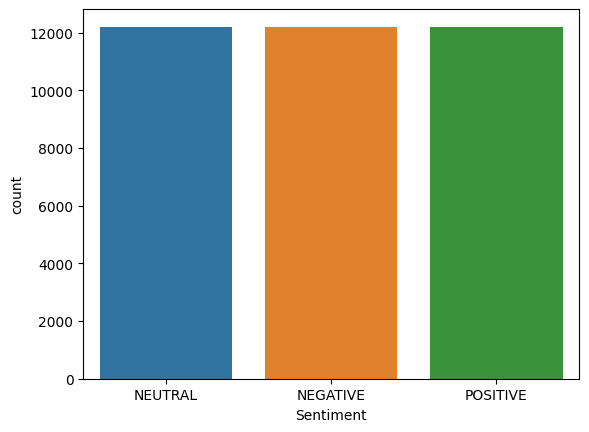

In [6]:
# Countplot for column Sentiment, Sentiment values are of the same number for each sentiment
sns.countplot(x='Sentiment',data=df)

<Axes: xlabel='Party', ylabel='count'>

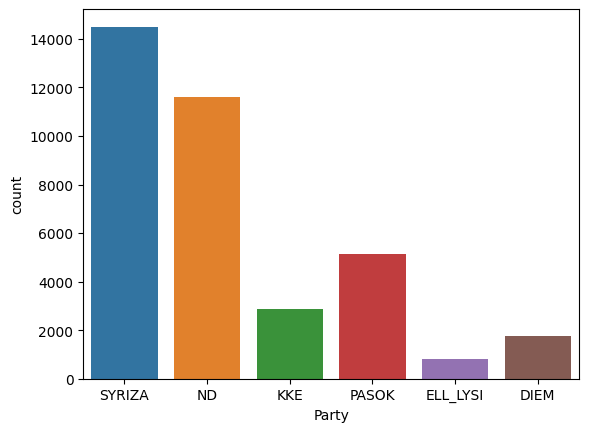

In [7]:
# Countplot for Parties , We can see that SYRIZA is the most prevalent party in the tweets dataset
sns.countplot(x='Party',data=df)

In [8]:
# Check for null values
df.isnull().sum()

# Create stop word list for word cloud and word frequency
stop_words = 'amp,Œ±Œ¥ŒπŒ±Œ∫ŒøœÄŒ±, Œ±Œπ, Œ±Œ∫ŒøŒºŒ±, Œ±Œ∫ŒøŒºŒ∑, Œ±Œ∫œÅŒπŒ≤œâœÇ, Œ±ŒªŒ∑Œ∏ŒµŒπŒ±, Œ±ŒªŒ∑Œ∏ŒπŒΩŒ±, Œ±ŒªŒªŒ±, Œ±ŒªŒªŒ±œáŒøœÖ, Œ±ŒªŒªŒµœÇ, Œ±ŒªŒªŒ∑, Œ±ŒªŒªŒ∑ŒΩ, Œ±ŒªŒªŒ∑œÇ, Œ±ŒªŒªŒπœâœÇ, Œ±ŒªŒªŒπœâœÑŒπŒ∫Œ±, Œ±ŒªŒªŒø, Œ±ŒªŒªŒøŒπ, Œ±ŒªŒªŒøŒπœâœÇ, Œ±ŒªŒªŒøŒπœâœÑŒπŒ∫Œ±, Œ±ŒªŒªŒøŒΩ, Œ±ŒªŒªŒøœÇ, Œ±ŒªŒªŒøœÑŒµ, Œ±ŒªŒªŒøœÖ, Œ±ŒªŒªŒøœÖœÇ, Œ±ŒªŒªœâŒΩ, Œ±ŒºŒ±, Œ±ŒºŒµœÉŒ±, Œ±ŒºŒµœÉœâœÇ, Œ±ŒΩ, Œ±ŒΩŒ±, Œ±ŒΩŒ±ŒºŒµœÉŒ±, Œ±ŒΩŒ±ŒºŒµœÑŒ±ŒæœÖ, Œ±ŒΩŒµœÖ, Œ±ŒΩœÑŒπ, Œ±ŒΩœÑŒπœÄŒµœÅŒ±, Œ±ŒΩœÑŒπœÇ, Œ±ŒΩœâ, Œ±ŒΩœâœÑŒµœÅœâ, Œ±ŒæŒ±œÜŒΩŒ±, Œ±œÄ, Œ±œÄŒµŒΩŒ±ŒΩœÑŒπ, Œ±œÄŒø, Œ±œÄŒøœàŒµ, Œ±œÅŒ±, Œ±œÅŒ±Œ≥Œµ, Œ±œÅŒ≥Œ±, Œ±œÅŒ≥ŒøœÑŒµœÅŒø, Œ±œÅŒπœÉœÑŒµœÅŒ±, Œ±œÅŒ∫ŒµœÑŒ±, Œ±œÅœáŒπŒ∫Œ±, Œ±œÇ, Œ±œÖœÅŒπŒø, Œ±œÖœÑŒ±, Œ±œÖœÑŒµœÇ, Œ±œÖœÑŒ∑, Œ±œÖœÑŒ∑ŒΩ, Œ±œÖœÑŒ∑œÇ, Œ±œÖœÑŒø, Œ±œÖœÑŒøŒπ, Œ±œÖœÑŒøŒΩ, Œ±œÖœÑŒøœÇ, Œ±œÖœÑŒøœÖ, Œ±œÖœÑŒøœÖœÇ, Œ±œÖœÑœâŒΩ, Œ±œÜŒøœÑŒøœÖ, Œ±œÜŒøœÖ, Œ≤ŒµŒ≤Œ±ŒπŒ±, Œ≤ŒµŒ≤Œ±ŒπŒøœÑŒ±œÑŒ±, Œ≥Œπ, Œ≥ŒπŒ±, Œ≥œÅŒ∑Œ≥ŒøœÅŒ±, Œ≥œÖœÅœâ, Œ¥Œ±, Œ¥Œµ, Œ¥ŒµŒπŒΩŒ±, Œ¥ŒµŒΩ, Œ¥ŒµŒæŒπŒ±, Œ¥Œ∑Œ∏ŒµŒΩ, Œ¥Œ∑ŒªŒ±Œ¥Œ∑, Œ¥Œπ, Œ¥ŒπŒ±, Œ¥ŒπŒ±œÅŒ∫œâœÇ, Œ¥ŒπŒ∫Œ±, Œ¥ŒπŒ∫Œø, Œ¥ŒπŒ∫ŒøŒπ, Œ¥ŒπŒ∫ŒøœÇ, Œ¥ŒπŒ∫ŒøœÖ, Œ¥ŒπŒ∫ŒøœÖœÇ, Œ¥ŒπŒøŒªŒøœÖ, Œ¥ŒπœÄŒªŒ±, Œ¥ŒπœáœâœÇ, ŒµŒ±ŒΩ, ŒµŒ±œÖœÑŒø, ŒµŒ±œÖœÑŒøŒΩ, ŒµŒ±œÖœÑŒøœÖ, ŒµŒ±œÖœÑŒøœÖœÇ, ŒµŒ±œÖœÑœâŒΩ, ŒµŒ≥Œ∫Œ±ŒπœÅŒ±, ŒµŒ≥Œ∫Œ±ŒπœÅœâœÇ, ŒµŒ≥œâ, ŒµŒ¥œâ, ŒµŒπŒ¥ŒµŒºŒ∑, ŒµŒπŒ∏Œµ, ŒµŒπŒºŒ±Œπ, ŒµŒπŒºŒ±œÉœÑŒµ, ŒµŒπŒΩŒ±Œπ, ŒµŒπœÇ, ŒµŒπœÉŒ±Œπ, ŒµŒπœÉŒ±œÉœÑŒµ, ŒµŒπœÉœÑŒµ, ŒµŒπœÑŒµ, ŒµŒπœáŒ±, ŒµŒπœáŒ±ŒºŒµ, ŒµŒπœáŒ±ŒΩ, ŒµŒπœáŒ±œÑŒµ, ŒµŒπœáŒµ, ŒµŒπœáŒµœÇ, ŒµŒ∫Œ±œÉœÑŒ±, ŒµŒ∫Œ±œÉœÑŒµœÇ, ŒµŒ∫Œ±œÉœÑŒ∑, ŒµŒ∫Œ±œÉœÑŒ∑ŒΩ, ŒµŒ∫Œ±œÉœÑŒ∑œÇ, ŒµŒ∫Œ±œÉœÑŒø, ŒµŒ∫Œ±œÉœÑŒøŒπ, ŒµŒ∫Œ±œÉœÑŒøŒΩ, ŒµŒ∫Œ±œÉœÑŒøœÇ, ŒµŒ∫Œ±œÉœÑŒøœÖ, ŒµŒ∫Œ±œÉœÑŒøœÖœÇ, ŒµŒ∫Œ±œÉœÑœâŒΩ, ŒµŒ∫ŒµŒπ, ŒµŒ∫ŒµŒπŒΩŒ±, ŒµŒ∫ŒµŒπŒΩŒµœÇ, ŒµŒ∫ŒµŒπŒΩŒ∑, ŒµŒ∫ŒµŒπŒΩŒ∑ŒΩ, ŒµŒ∫ŒµŒπŒΩŒ∑œÇ, ŒµŒ∫ŒµŒπŒΩŒø, ŒµŒ∫ŒµŒπŒΩŒøŒπ, ŒµŒ∫ŒµŒπŒΩŒøŒΩ, ŒµŒ∫ŒµŒπŒΩŒøœÇ, ŒµŒ∫ŒµŒπŒΩŒøœÖ, ŒµŒ∫ŒµŒπŒΩŒøœÖœÇ, ŒµŒ∫ŒµŒπŒΩœâŒΩ, ŒµŒ∫œÑŒøœÇ, ŒµŒºŒ±œÇ, ŒµŒºŒµŒπœÇ, ŒµŒºŒµŒΩŒ±, ŒµŒºœÄœÅŒøœÇ, ŒµŒΩ, ŒµŒΩŒ±, ŒµŒΩŒ±ŒΩ, ŒµŒΩŒ±œÇ, ŒµŒΩŒøœÇ, ŒµŒΩœÑŒµŒªœâœÇ, ŒµŒΩœÑŒøœÇ, ŒµŒΩœÑœâŒºŒµœÑŒ±ŒæœÖ, ŒµŒΩœâ, ŒµŒæ, ŒµŒæŒ±œÜŒΩŒ±, ŒµŒæŒ∑œÇ, ŒµŒæŒπœÉŒøœÖ, ŒµŒæœâ, ŒµœÄŒ±ŒΩœâ, ŒµœÄŒµŒπŒ¥Œ∑, ŒµœÄŒµŒπœÑŒ±, ŒµœÄŒπ, ŒµœÄŒπœÉŒ∑œÇ, ŒµœÄŒøŒºŒµŒΩœâœÇ, ŒµœÉŒ±œÇ, ŒµœÉŒµŒπœÇ, ŒµœÉŒµŒΩŒ±, ŒµœÉœÑœâ, ŒµœÉœÖ, ŒµœÑŒµœÅŒ±, ŒµœÑŒµœÅŒ±Œπ, ŒµœÑŒµœÅŒ±œÇ, ŒµœÑŒµœÅŒµœÇ, ŒµœÑŒµœÅŒ∑, ŒµœÑŒµœÅŒ∑œÇ, ŒµœÑŒµœÅŒø, ŒµœÑŒµœÅŒøŒπ, ŒµœÑŒµœÅŒøŒΩ, ŒµœÑŒµœÅŒøœÇ, ŒµœÑŒµœÅŒøœÖ, ŒµœÑŒµœÅŒøœÖœÇ, ŒµœÑŒµœÅœâŒΩ, ŒµœÑŒøœÖœÑŒ±, ŒµœÑŒøœÖœÑŒµœÇ, ŒµœÑŒøœÖœÑŒ∑, ŒµœÑŒøœÖœÑŒ∑ŒΩ, ŒµœÑŒøœÖœÑŒ∑œÇ, ŒµœÑŒøœÖœÑŒø, ŒµœÑŒøœÖœÑŒøŒπ, ŒµœÑŒøœÖœÑŒøŒΩ, ŒµœÑŒøœÖœÑŒøœÇ, ŒµœÑŒøœÖœÑŒøœÖ, ŒµœÑŒøœÖœÑŒøœÖœÇ, ŒµœÑŒøœÖœÑœâŒΩ, ŒµœÑœÉŒπ, ŒµœÖŒ≥Œµ, ŒµœÖŒ∏œÖœÇ, ŒµœÖœÑœÖœáœâœÇ, ŒµœÜŒµŒæŒ∑œÇ, ŒµœáŒµŒπ, ŒµœáŒµŒπœÇ, ŒµœáŒµœÑŒµ, ŒµœáŒ∏ŒµœÇ, ŒµœáŒøŒºŒµ, ŒµœáŒøœÖŒºŒµ, ŒµœáŒøœÖŒΩ, ŒµœáœÑŒµœÇ, Œµœáœâ, ŒµœâœÇ, Œ∑, Œ∑Œ¥Œ∑, Œ∑ŒºŒ±œÉœÑŒ±ŒΩ, Œ∑ŒºŒ±œÉœÑŒµ, Œ∑ŒºŒøœÖŒΩ, Œ∑œÉŒ±œÉœÑŒ±ŒΩ, Œ∑œÉŒ±œÉœÑŒµ, Œ∑œÉŒøœÖŒΩ, Œ∑œÑŒ±ŒΩ, Œ∑œÑŒ±ŒΩŒµ, Œ∑œÑŒøŒπ, Œ∑œÑœÑŒøŒΩ, Œ∏Œ±, Œπ, ŒπŒ¥ŒπŒ±, ŒπŒ¥ŒπŒ±ŒΩ, ŒπŒ¥ŒπŒ±œÇ, ŒπŒ¥ŒπŒµœÇ, ŒπŒ¥ŒπŒø, ŒπŒ¥ŒπŒøŒπ, ŒπŒ¥ŒπŒøŒΩ, ŒπŒ¥ŒπŒøœÇ, ŒπŒ¥ŒπŒøœÖ, ŒπŒ¥ŒπŒøœÖœÇ, ŒπŒ¥ŒπœâŒΩ, ŒπŒ¥ŒπœâœÇ, ŒπŒπ, ŒπŒπŒπ, ŒπœÉŒ±ŒºŒµ, ŒπœÉŒπŒ±, ŒπœÉœâœÇ,Œ∫,Œ∫Œ±Œ∏Œµ, Œ∫Œ±Œ∏ŒµŒºŒπŒ±, Œ∫Œ±Œ∏ŒµŒºŒπŒ±œÇ, Œ∫Œ±Œ∏ŒµŒΩŒ±, Œ∫Œ±Œ∏ŒµŒΩŒ±œÇ, Œ∫Œ±Œ∏ŒµŒΩŒøœÇ, Œ∫Œ±Œ∏ŒµœÑŒπ, Œ∫Œ±Œ∏ŒøŒªŒøœÖ, Œ∫Œ±Œ∏œâœÇ, Œ∫Œ±Œπ, Œ∫Œ±Œ∫Œ±, Œ∫Œ±Œ∫œâœÇ, Œ∫Œ±ŒªŒ±, Œ∫Œ±ŒªœâœÇ, Œ∫Œ±ŒºŒπŒ±, Œ∫Œ±ŒºŒπŒ±ŒΩ, Œ∫Œ±ŒºŒπŒ±œÇ, Œ∫Œ±ŒºœÄŒøœÉŒ±, Œ∫Œ±ŒºœÄŒøœÉŒµœÇ, Œ∫Œ±ŒºœÄŒøœÉŒ∑, Œ∫Œ±ŒºœÄŒøœÉŒ∑ŒΩ, Œ∫Œ±ŒºœÄŒøœÉŒ∑œÇ, Œ∫Œ±ŒºœÄŒøœÉŒø, Œ∫Œ±ŒºœÄŒøœÉŒøŒπ, Œ∫Œ±ŒºœÄŒøœÉŒøŒΩ, Œ∫Œ±ŒºœÄŒøœÉŒøœÇ, Œ∫Œ±ŒºœÄŒøœÉŒøœÖ, Œ∫Œ±ŒºœÄŒøœÉŒøœÖœÇ, Œ∫Œ±ŒºœÄŒøœÉœâŒΩ, Œ∫Œ±ŒΩŒµŒπœÇ, Œ∫Œ±ŒΩŒµŒΩ, Œ∫Œ±ŒΩŒµŒΩŒ±, Œ∫Œ±ŒΩŒµŒΩŒ±ŒΩ, Œ∫Œ±ŒΩŒµŒΩŒ±œÇ, Œ∫Œ±ŒΩŒµŒΩŒøœÇ, Œ∫Œ±œÄŒøŒπŒ±, Œ∫Œ±œÄŒøŒπŒ±ŒΩ, Œ∫Œ±œÄŒøŒπŒ±œÇ, Œ∫Œ±œÄŒøŒπŒµœÇ, Œ∫Œ±œÄŒøŒπŒø, Œ∫Œ±œÄŒøŒπŒøŒπ, Œ∫Œ±œÄŒøŒπŒøŒΩ, Œ∫Œ±œÄŒøŒπŒøœÇ, Œ∫Œ±œÄŒøŒπŒøœÖ, Œ∫Œ±œÄŒøŒπŒøœÖœÇ, Œ∫Œ±œÄŒøŒπœâŒΩ, Œ∫Œ±œÄŒøœÑŒµ, Œ∫Œ±œÄŒøœÖ, Œ∫Œ±œÄœâœÇ, Œ∫Œ±œÑ ,Œ∫Œ±œÑŒ±, Œ∫Œ±œÑŒπ, Œ∫Œ±œÑŒπœÑŒπ, Œ∫Œ±œÑŒøœÄŒπŒΩ, Œ∫Œ±œÑœâ, Œ∫ŒπŒøŒªŒ±œÇ,Œ∫Œπ, Œ∫ŒªœÄ, Œ∫ŒøŒΩœÑŒ±, Œ∫œÑŒª, Œ∫œÖœÅŒπœâœÇ, ŒªŒπŒ≥Œ±Œ∫Œπ, ŒªŒπŒ≥Œø, ŒªŒπŒ≥œâœÑŒµœÅŒø, ŒªŒøŒ≥œâ, ŒªŒøŒπœÄŒ±, ŒªŒøŒπœÄŒøŒΩ, ŒºŒ±, ŒºŒ±Œ∂Œπ, ŒºŒ±Œ∫Œ±œÅŒπ, ŒºŒ±Œ∫œÅœÖŒ±, ŒºŒ±ŒªŒπœÉœÑŒ±, ŒºŒ±ŒªŒªŒøŒΩ, ŒºŒ±œÇ, ŒºŒµ, ŒºŒµŒ∏Œ±œÖœÅŒπŒø, ŒºŒµŒπŒøŒΩ, ŒºŒµŒªŒµŒπ, ŒºŒµŒªŒªŒµœÑŒ±Œπ, ŒºŒµŒºŒπŒ±œÇ, ŒºŒµŒΩ, ŒºŒµœÅŒπŒ∫Œ±, ŒºŒµœÅŒπŒ∫ŒµœÇ, ŒºŒµœÅŒπŒ∫ŒøŒπ, ŒºŒµœÅŒπŒ∫ŒøœÖœÇ, ŒºŒµœÅŒπŒ∫œâŒΩ, ŒºŒµœÉŒ±, ŒºŒµœÑ, ŒºŒµœÑŒ±, ŒºŒµœÑŒ±ŒæœÖ, ŒºŒµœáœÅŒπ, ŒºŒ∑, ŒºŒ∑Œ¥Œµ, ŒºŒ∑ŒΩ, ŒºŒ∑œÄœâœÇ, ŒºŒ∑œÑŒµ, ŒºŒπŒ±, ŒºŒπŒ±ŒΩ, ŒºŒπŒ±œÇ, ŒºŒøŒªŒπœÇ, ŒºŒøŒªŒøŒΩŒøœÑŒπ, ŒºŒøŒΩŒ±œáŒ±, ŒºŒøŒΩŒµœÇ, ŒºŒøŒΩŒ∑, ŒºŒøŒΩŒ∑ŒΩ, ŒºŒøŒΩŒ∑œÇ, ŒºŒøŒΩŒø, ŒºŒøŒΩŒøŒπ, ŒºŒøŒΩŒøŒºŒπŒ±œÇ, ŒºŒøŒΩŒøœÇ, ŒºŒøŒΩŒøœÖ, ŒºŒøŒΩŒøœÖœÇ, ŒºŒøŒΩœâŒΩ, ŒºŒøœÖ, ŒºœÄŒøœÅŒµŒπ, ŒºœÄŒøœÅŒøœÖŒΩ, ŒºœÄœÅŒ±Œ≤Œø, ŒºœÄœÅŒøœÇ, ŒΩŒ±, ŒΩŒ±Œπ, ŒΩœâœÅŒπœÇ, ŒæŒ±ŒΩŒ±, ŒæŒ±œÜŒΩŒπŒ∫Œ±, Œø, ŒøŒπ, ŒøŒªŒ±, ŒøŒªŒµœÇ, ŒøŒªŒ∑, ŒøŒªŒ∑ŒΩ, ŒøŒªŒ∑œÇ, ŒøŒªŒø, ŒøŒªŒøŒ≥œÖœÅŒ±, ŒøŒªŒøŒπ, ŒøŒªŒøŒΩ, ŒøŒªŒøŒΩŒµŒΩ, ŒøŒªŒøœÇ, ŒøŒªŒøœÑŒµŒªŒ±, ŒøŒªŒøœÖ, ŒøŒªŒøœÖœÇ, ŒøŒªœâŒΩ, ŒøŒªœâœÇ, ŒøŒªœâœÉŒ¥ŒπŒøŒªŒøœÖ, ŒøŒºœâœÇ, ŒøœÄŒøŒπŒ±, ŒøœÄŒøŒπŒ±Œ¥Œ∑œÄŒøœÑŒµ, ŒøœÄŒøŒπŒ±ŒΩ, ŒøœÄŒøŒπŒ±ŒΩŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÄŒøŒπŒ±œÇ, ŒøœÄŒøŒπŒ±œÉŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÄŒøŒπŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÄŒøŒπŒµœÇ, ŒøœÄŒøŒπŒµœÉŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÄŒøŒπŒø, ŒøœÄŒøŒπŒøŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÄŒøŒπŒøŒπ, ŒøœÄŒøŒπŒøŒΩ, ŒøœÄŒøŒπŒøŒΩŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÄŒøŒπŒøœÇ, ŒøœÄŒøŒπŒøœÉŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÄŒøŒπŒøœÖ, ŒøœÄŒøŒπŒøœÖŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÄŒøŒπŒøœÖœÇ, ŒøœÄŒøŒπŒøœÖœÉŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÄŒøŒπœâŒΩ, ŒøœÄŒøŒπœâŒΩŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÄŒøœÑŒµ, ŒøœÄŒøœÑŒµŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÄŒøœÖ, ŒøœÄŒøœÖŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÄœâœÇ, ŒøœÅŒπœÉŒºŒµŒΩŒ±, ŒøœÅŒπœÉŒºŒµŒΩŒµœÇ, ŒøœÅŒπœÉŒºŒµŒΩœâŒΩ, ŒøœÅŒπœÉŒºŒµŒΩœâœÇ, ŒøœÉŒ±, ŒøœÉŒ±Œ¥Œ∑œÄŒøœÑŒµ, ŒøœÉŒµœÇ, ŒøœÉŒµœÉŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÉŒ∑, ŒøœÉŒ∑Œ¥Œ∑œÄŒøœÑŒµ, ŒøœÉŒ∑ŒΩ, ŒøœÉŒ∑ŒΩŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÉŒ∑œÇ, ŒøœÉŒ∑œÉŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÉŒø, ŒøœÉŒøŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÉŒøŒπ, ŒøœÉŒøŒπŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÉŒøŒΩ, ŒøœÉŒøŒΩŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÉŒøœÇ, ŒøœÉŒøœÉŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÉŒøœÖ, ŒøœÉŒøœÖŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÉŒøœÖœÇ, ŒøœÉŒøœÖœÉŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÉœâŒΩ, ŒøœÉœâŒΩŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÑŒ±ŒΩ, ŒøœÑŒπ, ŒøœÑŒπŒ¥Œ∑œÄŒøœÑŒµ, ŒøœÑŒøœÖ, ŒøœÖ, ŒøœÖŒ¥Œµ, ŒøœÖœÑŒµ, ŒøœáŒπ, œÄŒ±ŒªŒπ, œÄŒ±ŒΩœÑŒøœÑŒµ, œÄŒ±ŒΩœÑŒøœÖ, œÄŒ±ŒΩœÑœâœÇ, œÄŒ±œÅŒ±, œÄŒµœÅŒ±, œÄŒµœÅŒπ, œÄŒµœÅŒπœÄŒøœÖ, œÄŒµœÅŒπœÉœÉŒøœÑŒµœÅŒø, œÄŒµœÅœÉŒπ, œÄŒµœÅœÖœÉŒπ, œÄŒπŒ±, œÄŒπŒ∏Œ±ŒΩŒøŒΩ, œÄŒπŒø, œÄŒπœÉœâ, œÄŒªŒ±Œπ, œÄŒªŒµŒøŒΩ, œÄŒªŒ∑ŒΩ, œÄŒøŒπŒ±, œÄŒøŒπŒ±ŒΩ, œÄŒøŒπŒ±œÇ, œÄŒøŒπŒµœÇ, œÄŒøŒπŒø, œÄŒøŒπŒøŒπ, œÄŒøŒπŒøŒΩ, œÄŒøŒπŒøœÇ, œÄŒøŒπŒøœÖ, œÄŒøŒπŒøœÖœÇ, œÄŒøŒπœâŒΩ, œÄŒøŒªœÖ, œÄŒøœÉŒµœÇ, œÄŒøœÉŒ∑, œÄŒøœÉŒ∑ŒΩ, œÄŒøœÉŒ∑œÇ, œÄŒøœÉŒøŒπ, œÄŒøœÉŒøœÇ, œÄŒøœÉŒøœÖœÇ, œÄŒøœÑŒµ, œÄŒøœÖ, œÄŒøœÖŒ∏Œµ, œÄŒøœÖŒ∏ŒµŒΩŒ±, œÄœÅŒµœÄŒµŒπ, œÄœÅŒπŒΩ, œÄœÅŒø, œÄœÅŒøŒ∫ŒµŒπŒºŒµŒΩŒøœÖ, œÄœÅŒøŒ∫ŒµŒπœÑŒ±Œπ, œÄœÅŒøœÄŒµœÅœÉŒπ, œÄœÅŒøœÇ, œÄœÅŒøœÑŒøœÖ, œÄœÅŒøœáŒ∏ŒµœÇ, œÄœÅŒøœáœÑŒµœÇ, œÄœÅœâœÑœÖœÑŒµœÅŒ±, œÄœâœÇ, œÉŒ±ŒΩ, œÉŒ±œÇ, œÉŒµ, œÉŒµŒπœÇ, œÉŒ∑ŒºŒµœÅŒ±, œÉŒπŒ≥Œ±, œÉŒøœÖ, œÉœÑŒ±, œÉœÑŒ∑, œÉœÑŒ∑ŒΩ, œÉœÑŒ∑œÇ, œÉœÑŒπœÇ, œÉœÑŒø, œÉœÑŒøŒΩ, œÉœÑŒøœÖ, œÉœÑŒøœÖœÇ, œÉœÑœâŒΩ, œÉœÖŒ≥œáœÅŒøŒΩœâœÇ, œÉœÖŒΩ, œÉœÖŒΩŒ±ŒºŒ±, œÉœÖŒΩŒµœÄœâœÇ, œÉœÖŒΩŒ∑Œ∏œâœÇ, œÉœÖœáŒΩŒ±, œÉœÖœáŒΩŒ±œÇ, œÉœÖœáŒΩŒµœÇ, œÉœÖœáŒΩŒ∑, œÉœÖœáŒΩŒ∑ŒΩ, œÉœÖœáŒΩŒ∑œÇ, œÉœÖœáŒΩŒø, œÉœÖœáŒΩŒøŒπ, œÉœÖœáŒΩŒøŒΩ, œÉœÖœáŒΩŒøœÇ, œÉœÖœáŒΩŒøœÖ, œÉœÖœáŒΩŒøœÖ, œÉœÖœáŒΩŒøœÖœÇ, œÉœÖœáŒΩœâŒΩ, œÉœÖœáŒΩœâœÇ, œÉœáŒµŒ¥ŒøŒΩ, œÉœâœÉœÑŒ±, œÑŒ±, œÑŒ±Œ¥Œµ, œÑŒ±œÖœÑŒ±, œÑŒ±œÖœÑŒµœÇ, œÑŒ±œÖœÑŒ∑, œÑŒ±œÖœÑŒ∑ŒΩ, œÑŒ±œÖœÑŒ∑œÇ, œÑŒ±œÖœÑŒø,œÑŒ±œÖœÑŒøŒΩ, œÑŒ±œÖœÑŒøœÇ, œÑŒ±œÖœÑŒøœÖ, œÑŒ±œÖœÑœâŒΩ, œÑŒ±œáŒ±, œÑŒ±œáŒ±œÑŒµ, œÑŒµŒªŒπŒ∫Œ±, œÑŒµŒªŒπŒ∫œâœÇ, œÑŒµœÇ, œÑŒµœÑŒøŒπŒ±, œÑŒµœÑŒøŒπŒ±ŒΩ, œÑŒµœÑŒøŒπŒ±œÇ, œÑŒµœÑŒøŒπŒµœÇ, œÑŒµœÑŒøŒπŒø, œÑŒµœÑŒøŒπŒøŒπ, œÑŒµœÑŒøŒπŒøŒΩ, œÑŒµœÑŒøŒπŒøœÇ, œÑŒµœÑŒøŒπŒøœÖ, œÑŒµœÑŒøŒπŒøœÖœÇ, œÑŒµœÑŒøŒπœâŒΩ, œÑŒ∑, œÑŒ∑ŒΩ, œÑŒ∑œÇ, œÑŒπ, œÑŒπœÄŒøœÑŒ±, œÑŒπœÄŒøœÑŒµ, œÑŒπœÇ, œÑŒø, œÑŒøŒπ, œÑŒøŒΩ, œÑŒøœÇ, œÑŒøœÉŒ±, œÑŒøœÉŒµœÇ, œÑŒøœÉŒ∑, œÑŒøœÉŒ∑ŒΩ, œÑŒøœÉŒ∑œÇ, œÑŒøœÉŒø, œÑŒøœÉŒøŒπ, œÑŒøœÉŒøŒΩ, œÑŒøœÉŒøœÇ, œÑŒøœÉŒøœÖ, œÑŒøœÉŒøœÖœÇ, œÑŒøœÉœâŒΩ, œÑŒøœÑŒµ, œÑŒøœÖ, œÑŒøœÖŒªŒ±œáŒπœÉœÑŒø, œÑŒøœÖŒªŒ±œáŒπœÉœÑŒøŒΩ, œÑŒøœÖœÇ, œÑŒøœÖœÑŒ±, œÑŒøœÖœÑŒµœÇ, œÑŒøœÖœÑŒ∑, œÑŒøœÖœÑŒ∑ŒΩ, œÑŒøœÖœÑŒ∑œÇ, œÑŒøœÖœÑŒø, œÑŒøœÖœÑŒøŒπ, œÑŒøœÖœÑŒøŒπœÇ, œÑŒøœÖœÑŒøŒΩ, œÑŒøœÖœÑŒøœÇ, œÑŒøœÖœÑŒøœÖ, œÑŒøœÖœÑŒøœÖœÇ, œÑŒøœÖœÑœâŒΩ, œÑœÖœáŒøŒΩ, œÑœâŒΩ, œÑœâœÅŒ±, œÖœÄ, œÖœÄŒµœÅ, œÖœÄŒø, œÖœÄŒøœàŒ∑, œÖœÄŒøœàŒπŒΩ, œÖœÉœÑŒµœÅŒ±, œÜŒµœÑŒøœÇ, œáŒ±ŒºŒ∑ŒªŒ±, œáŒ∏ŒµœÇ, œáœÑŒµœÇ, œáœâœÅŒπœÇ, œáœâœÅŒπœÉœÑŒ±, œàŒ∑ŒªŒ±, œâ, œâœÅŒ±ŒπŒ±, œâœÇ, œâœÉŒ±ŒΩ, œâœÉŒøœÑŒøœÖ, œâœÉœÄŒøœÖ, œâœÉœÑŒµ, œâœÉœÑŒøœÉŒø, œâœá'


stop_words_separated = stop_words.split(",")
stop_words_separated = [w.strip() for w in stop_words_separated] # remove whitespaces

# remove diacritics
d = {ord('\N{COMBINING ACUTE ACCENT}'):None}

for word in stop_words_separated:
    word = ud.normalize('NFD',word).translate(d)

print('Stop words created.')

Stop words created.


In [9]:
# Data cleanup
# Remove all useless characters from tweets (URLs, Hashtags, mentions (at signs), punctuations)
# also removes mentioned accounts after hashtags and @ signs and special symbols.
def clean_tweet(tweet):
    '''
    Function to clean a tweet text by removing the links, punctuations, hashtags, mentions symbols and every text after mentions and hashtags
    using regex expressions. Also removes special symbols.
    Parameters:
       tweet (string): Tweet text to transform.
    Returns:
       tweet_cleaned (string): Tweet without links, punctuations, hashtags, ,mentions symbols and every text after mentions and hashtags. Also removes special symbols.
    """
    '''
    # convert the tweet text to lowercase letters
    tweet_lower = tweet.lower()
    # remove links, punctuations, hashtags, ,mentions and other symbols
    tweet_cleaned = re.sub(u"(http\S+)|([‚Äú‚Äù!?.¬ª¬´,:;()\"'%&-_|‚Äì‚Ç¨$ŒÑ#])|([#@]\S+)", "", tweet_lower)
    
    return tweet_cleaned

# Apply function to all tweets (text column)
df['Text'] = [clean_tweet(tweet) for tweet in df['Text']]
test_df['Text'] = [clean_tweet(tweet) for tweet in test_df['Text']]
valid_df['Text'] = [clean_tweet(tweet) for tweet in valid_df['Text']]

def find_english_words(text):
    return re.findall(r'\b[a-zA-Z]+\b', text)

english_words = [find_english_words(text) for text in df['Text']]
test_english_words = [find_english_words(text) for text in test_df['Text']]
valid_english_words = [find_english_words(text) for text in valid_df['Text']]

def lists_to_list_skip_empty(list_of_lists):
    # Flatten the list of lists, skipping empty lists
    flat_list = [item for sublist in list_of_lists if sublist for item in sublist]
    return flat_list

final_list = lists_to_list_skip_empty(english_words)
final_list_no_dupes = list(set(final_list))

test_final_list = lists_to_list_skip_empty(test_english_words)
test_final_list_no_dupes = list(set(test_final_list))

valid_final_list = lists_to_list_skip_empty(valid_english_words)
valid_final_list_no_dupes = list(set(valid_final_list))

stop_words_separated.extend(final_list_no_dupes) # add English words to stop words so they can be removed.
stop_words_separated.extend(test_final_list_no_dupes)
stop_words_separated.extend(valid_final_list_no_dupes)

# remove diacritics from Text column
text_no_diacritics = []
test_no_diacritics = []
valid_no_diacritics = []

d = {ord('\N{COMBINING ACUTE ACCENT}'):None}
for tweet in df['Text']:
    text1 = ud.normalize('NFD',tweet).translate(d)
    text_no_diacritics.append(text1)
    
for tweet in test_df['Text']:
    text2 = ud.normalize('NFD',tweet).translate(d)
    test_no_diacritics.append(text2)

for tweet in valid_df['Text']:
    text3 = ud.normalize('NFD',tweet).translate(d)
    valid_no_diacritics.append(text3)
    
df['Text'] = text_no_diacritics
test_df['Text'] = test_no_diacritics
valid_df['Text'] = valid_no_diacritics

# Remove stop_words from text column
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_separated)]))
test_df['Text'] = test_df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_separated)]))
valid_df['Text'] = valid_df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_separated)]))

print(df['Text']) # making sure the cleanup works.
print('\n')
print('TEST SET BELOW')
print(test_df['Text'])
print('\n')
print('VALID SET BELOW')
print(valid_df['Text'])

# Using pandarallel for faster tokenization and lemmatization.
# pandarallel.initialize(progress_bar=True)

# I added comments to these columns as they took a considerable amount of time to be finished , and they're not usable
# since they produce worse results.
# df['Docs'] = df['Text'].parallel_apply(lambda x: nlp(x)) # add docs to dataframe in order to get tokens
# df['Lemmas'] = df['Text'].parallel_apply(lambda row: " ".join([w.lemma_ for w in nlp(row)])) # add lemmas to dataframe
print("Text cleanup complete.")

0        Œ±œÄŒøŒªœÖŒºŒ±ŒΩœÉŒ∑Œ∫ŒøœÅŒπŒøŒπ Œ±œÄŒµŒΩœÑŒøŒºœâœÉŒ∑Œ∫ŒøœÅŒπŒøœÇ Œ±œÄŒøŒªœÖŒºŒ±ŒΩœÉŒµŒπœÇ...
1        ŒµŒæŒπ ŒΩŒµŒµœÇ ŒµœÄŒπœÉœÑŒøŒªŒµœÇ ŒºŒ±Œ∫ŒµŒ¥ŒøŒΩŒπŒ± Œ∫Œ±ŒπŒΩŒµ ŒΩŒ¥ ŒºŒ∑œÑœÉŒøœÑŒ±Œ∫...
2         ŒπœÉœáœÖœÅŒø Œ∫Œ∫Œµ Œ¥œÖŒΩŒ±ŒºŒ∑ ŒªŒ±ŒøœÖ Œ≤ŒøœÖŒªŒ∑ Œ∫Œ±Œ∏Œ∑ŒºŒµœÅŒπŒΩŒøœÖœÇ Œ±Œ≥œâŒΩŒµœÇ
3                      ŒºŒΩŒ∑ŒºŒøŒΩŒπŒ±Œ∫ŒøœÑŒ±œÑŒø ŒºŒµœÅŒ± ŒµŒ∫ŒªŒøŒ≥ŒµœÇ œÑœâœÅŒ±Œ∫Œ∫Œµ
4                         œÉœÖŒ≥Œ∫ŒªŒøŒΩŒπœÉœÑŒπŒ∫Œø œàœÖœáŒ±œÉŒ∏ŒµŒΩŒµŒπŒ± œÑœÉŒπœÄœÅŒ±
                               ...                        
36625    Œ∫ŒøœÖŒªŒ∑œÇ ŒºŒ∑œÑœÉŒøœÑŒ±Œ∫Œ∑œÇ ŒªŒµŒµŒπ œàŒµŒºŒ±œÑŒ±Œ¥ŒµŒΩ Œ±Œ¥ŒµŒπŒ±œÉŒµ ŒºœÄŒ±ŒºœÄ...
36626    œÄœÅŒøœÉŒµŒæŒµ œÉŒ∫ŒπœÉŒµŒπ Œ∫Œ±ŒªœÉŒøŒΩ œáŒ±ŒªŒπŒ± ŒΩŒµŒ± œÜœâœÑŒøŒ≥œÅŒ±œÜŒπŒ± ŒøŒºŒø...
36627    Œ∏ŒµœÉŒ∑ Œ∫Œ∫Œµ Œ±œÉœÜŒ±ŒªŒµŒπŒ± œÄŒøŒªŒπœÑœâŒΩ Œ¥ŒπŒ±œÜŒøœÅŒøœÖœÇ œÅŒøœÖŒ≤ŒπŒ∫œâŒΩŒµœÇ...
36628    ŒºŒ±œÅŒ∑ Œ∫Œ±Œ∫ŒøŒºŒøŒπœÅŒ± Œ∏œÖŒ≥Œ±œÑŒµœÅŒ± ŒΩŒ±Œ∂ŒπœÉœÑŒ∑ Œ±ŒΩœÑŒπœÉŒ∑ŒºŒπœÑŒ∑ ŒæŒµœÜ...
36629                              ŒµŒΩœÑŒ±ŒæŒµŒπ ŒµœÄŒµŒπœ

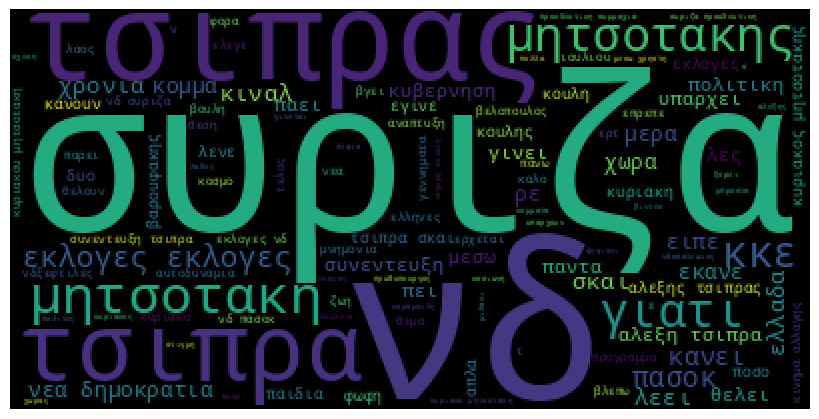

In [10]:
# Creating some visualizations with tokens
# Word cloud
tweets = []
for tweet in df['Text']:
    #tokens.append(doc.text)
    tweets.append(tweet)
    


# stop_words = stopwords.words('greek')
for i in range(len(tweets)):
        tweets[i] = tweets[i].lower()


# remove Diacritics in Greek (tonous)
d = {ord('\N{COMBINING ACUTE ACCENT}'):None}
tweets_string = "".join(tweets)
tweets_without_accent = ud.normalize('NFD',tweets_string).translate(d)


wordcloud = WordCloud(stopwords=stop_words_separated).generate(str(tweets_without_accent))
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

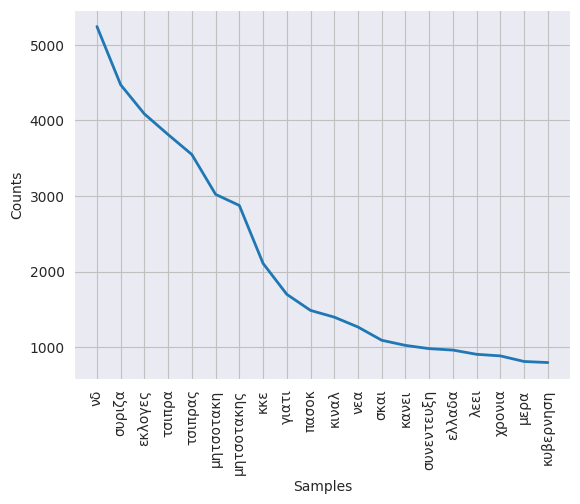

In [11]:
# Tokens frequency diagram
tokens = nltk.word_tokenize(tweets_without_accent)
sns.set_style('darkgrid')
nlp_words=nltk.FreqDist(tokens)
nlp_words.plot(20);

In [12]:
# X = df['Lemmas'] # Lemma as feature, doesn't really increase performance of f1-score.
# X = df['Tokens'] # same as above for tokens.
X_train = df['Text'] # 40% f1-score , best feature as of yet
X_test = test_df['Text']
y_train = df['Sentiment'] # labels

X_valid = valid_df['Text']
y_valid = valid_df['Sentiment'] # these two will be used for metrics

def simple_tokenizer(sentence):
    tokens = sentence.split()  # Split the sentence into a list of words
    return tokens

# tokenize text column and perform below processes for all datasets.
df['Tokens'] = df['Text'].apply(simple_tokenizer)
test_df['Tokens'] = test_df['Text'].apply(simple_tokenizer)
valid_df['Tokens'] = valid_df['Text'].apply(simple_tokenizer)

# Train Word2Vec model
sentences = df['Tokens'].tolist()
test_sentences = test_df['Tokens'].tolist()
valid_sentences = valid_df['Tokens'].tolist()

word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Creates embeddings for each tweet
def get_tweet_embedding(tweet):
    word_embeddings = [word2vec_model.wv[word] for word in tweet if word in word2vec_model.wv]
    if not word_embeddings:
        zeroes_list = [0] * 100
        return zeroes_list
            
#         return None  # Handle the case where no words have embeddings
    tweet_embedding = sum(word_embeddings) / len(word_embeddings)  # Simple average
    return tweet_embedding

# Convert tweet tokens to embeddings
tweet_embeddings_train = [get_tweet_embedding(tweet) for tweet in sentences]
tweet_embeddings_test = [get_tweet_embedding(tweet) for tweet in test_sentences]
tweet_embeddings_valid = [get_tweet_embedding(tweet) for tweet in valid_sentences]


# Convert labels to one-hot encoded tensors
label_embeddings_train = pd.get_dummies(df['Sentiment']).values
label_embeddings_valid = pd.get_dummies(valid_df['Sentiment']).values

# Below part is used to correlate the numbers 0,1,2 to their respective labels (POSITIVE,NEUTRAL,NEGATIVE) for predictions
label_encoded_train = pd.get_dummies(df['Sentiment'])
label_encoded_valid = pd.get_dummies(valid_df['Sentiment'])

label_mapping_train = {i: label for i, label in enumerate(label_encoded_train.columns)}
label_mapping_valid = {i: label for i, label in enumerate(label_encoded_valid.columns)}

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(tweet_embeddings_train)
y_train_tensor = torch.FloatTensor(label_embeddings_train)

X_test_tensor = torch.FloatTensor(tweet_embeddings_test)

X_valid_tensor = torch.FloatTensor(tweet_embeddings_valid)
y_valid_tensor = torch.FloatTensor(label_embeddings_valid)


print('X_train_tensor shape:', X_train_tensor.shape)
print('y_train_tensor shape:', y_train_tensor.shape)

print('X_test_tensor shape: ', X_test_tensor.shape)

print('X_valid_tensor shape: ', X_valid_tensor.shape)
print('y_valid_tensor shape: ', y_valid_tensor.shape)

/tmp/ipykernel_19/79449557.py:55: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X_train_tensor = torch.FloatTensor(tweet_embeddings_train)


X_train_tensor shape: torch.Size([36630, 100])
y_train_tensor shape: torch.Size([36630, 3])
X_test_tensor shape:  torch.Size([10470, 100])
X_valid_tensor shape:  torch.Size([5232, 100])
y_valid_tensor shape:  torch.Size([5232, 3])


In [13]:
X_train_tensor = X_train_tensor.unsqueeze(1)  # Adds a dimension at index 1
X_valid_tensor = X_valid_tensor.unsqueeze(1)
X_test_tensor = X_test_tensor.unsqueeze(1)

#Initialise dataloaders
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor) #class to represent the data as list of tensors. x=input_features, y=labels
test_dataset = torch.utils.data.TensorDataset(X_test_tensor)
valid_dataset = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)

print('Data loading complete.')

Data loading complete.


## most similar word visualization

In [14]:
# Picking some common words to show visualizations
most_similar_mitsotakis = word2vec_model.wv.most_similar('ŒºŒ∑œÑœÉŒøœÑŒ±Œ∫Œ∑œÇ')

print(f'Most semantically similar to word Mitsotakis:')
print(f'\n{" "*5}word{" "*10}  similarity score')
print(f'{"="*43}')
for w in most_similar_mitsotakis:
    print(f'{" "*5}{w[0]:15}{w[1]}')

Most semantically similar to word Mitsotakis:

     word            similarity score
     ŒºŒ∑œÑœÉŒøœÑŒ±Œ∫Œ∑œÇ‚Ä¶    0.9547027349472046
     œáœâœÅœâŒΩ          0.9515827298164368
     Œ∂Œ∑œÑŒ∑œÉŒµ         0.9509779810905457
     Œ¥ŒπŒ±œÜŒøœÅŒµœÑŒπŒ∫ŒøœÇ   0.9440712332725525
     Œ±œÄŒµŒªŒµœÖŒ∏ŒµœÅœâœÉŒµ   0.9418005347251892
     ŒºŒ±Œ∫œÅœÖŒΩŒπœÑœÉŒ±     0.9397727847099304
     œÉœÖŒΩŒøŒ¥ŒøœÇ        0.9377662539482117
     œÖœÄŒµœÅŒ∑œÜŒ±ŒΩŒøœÖœÇ    0.9341276288032532
     Œ±Œ≤œÅŒ±ŒºŒøœÄŒøœÖŒªŒøœÇ   0.9335430860519409
     Œ±œÄŒøŒ¥ŒµŒπœáŒ∏ŒµŒπ     0.9329411387443542


In [15]:
most_similar_tsipras = word2vec_model.wv.most_similar('œÑœÉŒπœÄœÅŒ±œÇ')

print(f'Most semantically similar to word Tsipras:')
print(f'\n{" "*5}word{" "*10}  similarity score')
print(f'{"="*43}')
for w in most_similar_tsipras:
    print(f'{" "*5}{w[0]:15}{w[1]}')

Most semantically similar to word Tsipras:

     word            similarity score
     ŒæŒµŒ≤œÅŒ±Œ∫œâŒºŒ±      0.9591887593269348
     üî¥              0.9571133852005005
     œÉœÖŒºŒ≤ŒπŒ≤Œ±œÉœÑŒ∑Œ∫Œ±ŒºŒµ 0.9513048529624939
     œÉœÄŒ±ŒµŒπ          0.9492200613021851
     ŒºŒµœÑŒ±ŒΩŒπœâŒΩœâ      0.9466826319694519
     œÉŒ∫Œ±ŒπœÑœÉŒπœÄœÅŒ±œÇ    0.9450240135192871
     œÑœÉŒπœÄœÅŒ±œÇœÉœÖŒΩœÑŒ±Œ≥ŒºŒ±0.944040834903717
     œÄœÅœâŒπŒΩŒµœÇ        0.9435499310493469
     Œ±ŒΩŒ±Œ∫ŒøŒπŒΩœâŒΩŒµŒπ    0.9427955746650696
     Œ∂Œ±Œ≥ŒøœÅŒ±         0.9409149885177612


## Linear substructure visualization

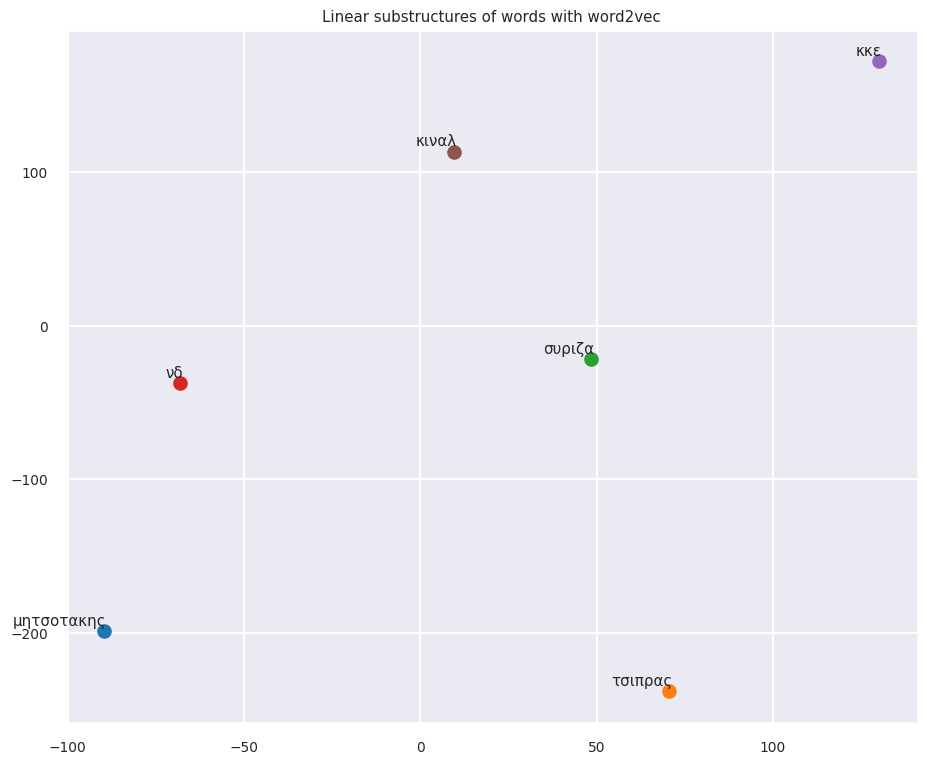

In [16]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.manifold import TSNE

sns.set_style("darkgrid")
sns.set_context("talk",  font_scale=0.6)

vocab = ["ŒºŒ∑œÑœÉŒøœÑŒ±Œ∫Œ∑œÇ", "œÑœÉŒπœÄœÅŒ±œÇ", "œÉœÖœÅŒπŒ∂Œ±", "ŒΩŒ¥", "Œ∫Œ∫Œµ", "Œ∫ŒπŒΩŒ±Œª"]

def glove_plot(model):
    labels = []
    wordvecs = []

    for word in vocab:
        wordvecs.append(model.wv[word])
        labels.append(word)
    
    wordvecs_array = np.array(wordvecs)
    tsne_model = TSNE(perplexity=3, n_components=2, init='pca', random_state=42) #T-distributed Stochastic Neighbor Embedding
    coordinates = tsne_model.fit_transform(wordvecs_array) #The fit method is calculating the mean and variance of each of the features present in our data. The transform method is transforming all the features using the respective mean and variance.

    x = []
    y = []
    for value in coordinates:
        x.append(value[0])
        y.append(value[1])


    plt.figure(figsize=(11,9))
    plt.title('Linear substructures of words with word2vec')
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(2, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

glove_plot(word2vec_model)

## RNN creation (Stacked and bidirectional)

In [17]:
# RNN stacked bi-directional model
class RNN(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, output_size, num_hidden_layers):
        super(RNN, self).__init__()
        
        cells = {
          "RNN" : nn.RNN,
          "LSTM"    : nn.LSTM,
          "GRU"     : nn.GRU
        }

        self.cell_type = cell_type

        self.rnn = cells[cell_type](         # Pick the specific model
            input_size = input_size,           # Number of features for each time step
            hidden_size = hidden_size,         # rnn hidden units
            batch_first = True, # input & output will have batch size as 1s dimension. e.g. (batch, time_step, input_size)
            bidirectional = True, # making RNN bidirectional
            num_layers = num_hidden_layers, # Making RNN stacked with additional layers
            dropout = 0.2 # Using dropout
        )
        
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True,bidirectional=True,num_layers=2,dropout=0.2)
        
        # Adding more hidden layers based on parameter
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_size * 2, hidden_size * 2))
        
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        if self.cell_type == 'LSTM':
            r_out, (h_n, h_c) = self.rnn(x)
        else:
            r_out, h_n = self.rnn(x)
#         r_out, _ = self.lstm(x)
        
        # Pass through additional hidden layers with ReLU activation
        for layer in self.hidden_layers:
            r_out = F.relu(layer(r_out))
        
        output = self.fc(r_out[:, -1, :])  # Take the output from the last time step
        return output

## Training and evaluation

In [18]:
# Hyperparameters
input_size = 100 
hidden_size = 50  
output_size = 3 
learning_rate = 0.001
epochs = 15
num_hidden_layers = 2

# Create the model, loss function, and optimizer
cell_type = 'LSTM'
# net = RNN(cell_type, input_size, hidden_size, output_size) # 
model = RNN(cell_type, input_size, hidden_size, output_size, num_hidden_layers)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train NN for one epoch so we can get Learning curve for steps.

for epoch in range(1):
    batch_losses = []
    for x_batch, y_batch in train_dataloader:
        y_pred = model(x_batch)

        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # print('y_pred=', y_pred[0])
        #Delete previously stored gradients
        optimizer.zero_grad()
        #Perform backpropagation starting from the loss calculated in this epoch
        
        loss.backward()
        #Update model's weights based on the gradients calculated during backprop
        optimizer.step()
    
#     print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(train_dataloader):.5f}")
    
    model.eval()
    with torch.no_grad():
        valid_batch_losses = []
        for x_batch, y_batch in valid_dataloader:
            y_pred_valid = model(x_batch)
            # Compute and print/validation loss or other metrics
            valid_loss = loss_func(y_pred_valid, y_batch)
            valid_batch_losses.append(valid_loss.item())
    
    # Check validation loss to make sure we don't get overfitting
    print(f'Epoch {epoch:3} \t\t Training Loss: {sum(batch_losses)/len(train_dataloader):.5f} \t\t Validation Loss: {sum(valid_batch_losses) / len(valid_dataloader):.5f}')

    
# Plot results (Learning curve)
plt.figure(figsize=(12,5))
plt.plot(batch_losses)
plt.title('Learning Curve')
plt.xlabel('# of steps', fontsize=12)
plt.ylabel('CE - Loss', fontsize=12)
plt.show()

Epoch   0 		 Training Loss: 1.09487 		 Validation Loss: 1.09088


In [19]:
# LSTM run
# Hyperparameters
input_size = 100 
hidden_size = 50  
output_size = 3 
learning_rate = 0.001
num_hidden_layers = 2
f1_scores = {} # here I will save all f1 scores and later on get the best NN's results
valid_preds = {} # here I will save all valid predictions and later on get the best NN's results
test_preds = {} # here I will save all test predictions and later on get the best NN's results


# Create the model, loss function, and optimizer
cell_type = 'LSTM'
# net = RNN(cell_type, input_size, hidden_size, output_size) # 
model = RNN(cell_type,input_size, hidden_size, output_size, num_hidden_layers)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Best number for now: 60
for epoch in range(60):
    batch_losses = []
    for x_batch, y_batch in train_dataloader:
        y_pred = model(x_batch)

        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # print('y_pred=', y_pred[0])
        #Delete previously stored gradients
        optimizer.zero_grad()
        #Perform backpropagation starting from the loss calculated in this epoch
        
        loss.backward()
        #Update model's weights based on the gradients calculated during backprop
        optimizer.step()
    
#     print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(train_dataloader):.5f}")
    
    model.eval()
    with torch.no_grad():
        valid_batch_losses = []
        for x_batch, y_batch in valid_dataloader:
            y_pred_valid = model(x_batch)
            # Compute and print/validation loss or other metrics
            valid_loss = loss_func(y_pred_valid, y_batch)
            valid_batch_losses.append(valid_loss.item())
    
    # Check validation loss to make sure we don't get overfitting
    print(f'Epoch {epoch:3} \t\t Training Loss: {sum(batch_losses)/len(train_dataloader):.5f} \t\t Validation Loss: {sum(valid_batch_losses) / len(valid_dataloader):.5f}')


# Test set predictions
# Generate test predictions and evaluate test set
model.eval()
predictions_test = []

# test results, labels for submission.csv
with torch.no_grad():
    for inputs in test_dataloader:
        for tensor in inputs:
            outputs = model(tensor)
            _, predicted = torch.max(outputs, 1)

            predictions_test.extend(predicted.tolist())
    
# convert 0,1,2 predictions to their original text form (POSITIVE, NEUTRAL , NEGATIVE)
# these will also be put in the submission.csv
original_label_predictions_test_lstm = [label_mapping_train[pred] for pred in predictions_test]

# Generate valid predictions
predictions_valid = []

val_targets = []
model.eval()
# valid results for evaluation
with torch.no_grad():
    for x_batch, y_batch in valid_dataloader:
        outputs = model(x_batch)
        _, predicted = torch.max(outputs, 1)

        predictions_valid.extend(predicted.tolist())
        val_targets.extend(y_batch.tolist())
    
# convert indexes to respective labels and predictions to respective label (POSITIVE, NEGATIVE, NEUTRAL) and feed them to the metric functions 
original_label_predictions_valid_lstm  = [label_mapping_valid[pred] for pred in predictions_valid]
val_targets_indices = [np.argmax(label) if np.sum(label) > 0 else -1 for label in val_targets]
original_labels_valid = [label_mapping_valid[label] for label in val_targets_indices]

print("\n")
print("================= LSTM NN SCORES =================")
print(classification_report(original_labels_valid,original_label_predictions_valid_lstm))

lstm_f1 = f1_score(original_labels_valid,original_label_predictions_valid_lstm,average='micro')
f1_scores['lstm'] = lstm_f1
valid_preds['lstm'] = original_label_predictions_valid_lstm
test_preds['lstm'] = original_label_predictions_test_lstm
print("accuracy: ",accuracy_score(original_labels_valid,original_label_predictions_valid_lstm))
print("f1: ",f1_score(original_labels_valid,original_label_predictions_valid_lstm,average='micro'))
print("total f1: ",f1_score(original_labels_valid,original_label_predictions_valid_lstm,average=None))

Epoch   0 		 Training Loss: 1.09493 		 Validation Loss: 1.09273
Epoch   1 		 Training Loss: 1.09113 		 Validation Loss: 1.08912
Epoch   2 		 Training Loss: 1.08947 		 Validation Loss: 1.08883
Epoch   3 		 Training Loss: 1.08946 		 Validation Loss: 1.08685
Epoch   4 		 Training Loss: 1.08818 		 Validation Loss: 1.08741
Epoch   5 		 Training Loss: 1.08617 		 Validation Loss: 1.08391
Epoch   6 		 Training Loss: 1.08478 		 Validation Loss: 1.08344
Epoch   7 		 Training Loss: 1.08344 		 Validation Loss: 1.08543
Epoch   8 		 Training Loss: 1.08273 		 Validation Loss: 1.08245
Epoch   9 		 Training Loss: 1.08216 		 Validation Loss: 1.07902
Epoch  10 		 Training Loss: 1.08237 		 Validation Loss: 1.08022
Epoch  11 		 Training Loss: 1.08098 		 Validation Loss: 1.07780
Epoch  12 		 Training Loss: 1.08073 		 Validation Loss: 1.07930
Epoch  13 		 Training Loss: 1.08017 		 Validation Loss: 1.07646
Epoch  14 		 Training Loss: 1.07910 		 Validation Loss: 1.07527
Epoch  15 		 Training Loss: 1.07882 		 V

In [20]:
# RNN Run
# Hyperparameters
input_size = 100 
hidden_size = 50  
output_size = 3 
learning_rate = 0.001
epochs = 15
num_hidden_layers = 2

# Create the model, loss function, and optimizer
cell_type = 'RNN'
# net = RNN(cell_type, input_size, hidden_size, output_size) # 
rnn_model = RNN(cell_type,input_size, hidden_size, output_size, num_hidden_layers)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)


for epoch in range(60):
    batch_losses = []
    for x_batch, y_batch in train_dataloader:
        y_pred = rnn_model(x_batch)

        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # print('y_pred=', y_pred[0])
        #Delete previously stored gradients
        optimizer.zero_grad()
        #Perform backpropagation starting from the loss calculated in this epoch
        
        loss.backward()
        #Update model's weights based on the gradients calculated during backprop
        optimizer.step()
    
#     print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(train_dataloader):.5f}")
    
    rnn_model.eval()
    with torch.no_grad():
        valid_batch_losses = []
        for x_batch, y_batch in valid_dataloader:
            y_pred_valid = rnn_model(x_batch)
            # Compute and print/validation loss or other metrics
            valid_loss = loss_func(y_pred_valid, y_batch)
            valid_batch_losses.append(valid_loss.item())
    
    # Check validation loss to make sure we don't get overfitting
    print(f'Epoch {epoch:3} \t\t Training Loss: {sum(batch_losses)/len(train_dataloader):.5f} \t\t Validation Loss: {sum(valid_batch_losses) / len(valid_dataloader):.5f}')


# Test set predictions
# Generate test predictions and evaluate test set
rnn_model.eval()
predictions_test = []

# test results, labels for submission.csv
with torch.no_grad():
    for inputs in test_dataloader:
        for tensor in inputs:
            outputs = rnn_model(tensor)
            _, predicted = torch.max(outputs, 1)

            predictions_test.extend(predicted.tolist())
    
# convert 0,1,2 predictions to their original text form (POSITIVE, NEUTRAL , NEGATIVE)
# these will also be put in the submission.csv
original_label_predictions_test_rnn = [label_mapping_train[pred] for pred in predictions_test]

# Generate valid predictions
predictions_valid = []

val_targets = []
rnn_model.eval()
# valid results for evaluation
with torch.no_grad():
    for x_batch, y_batch in valid_dataloader:
        outputs = rnn_model(x_batch)
        _, predicted = torch.max(outputs, 1)

        predictions_valid.extend(predicted.tolist())
        val_targets.extend(y_batch.tolist())
    
# convert indexes to respective labels and predictions to respective label (POSITIVE, NEGATIVE, NEUTRAL) and feed them to the metric functions 
original_label_predictions_valid_rnn = [label_mapping_valid[pred] for pred in predictions_valid]
val_targets_indices = [np.argmax(label) if np.sum(label) > 0 else -1 for label in val_targets]
original_labels_valid = [label_mapping_valid[label] for label in val_targets_indices]

print("\n")
print("================= RNN SCORES =================")
print(classification_report(original_labels_valid,original_label_predictions_valid_rnn))

rnn_f1 = f1_score(original_labels_valid,original_label_predictions_valid_rnn,average='micro')
f1_scores['rnn'] = rnn_f1
valid_preds['rnn'] = original_label_predictions_valid_rnn
test_preds['rnn'] = original_label_predictions_test_rnn
print("accuracy: ",accuracy_score(original_labels_valid,original_label_predictions_valid_rnn))
print("f1: ",f1_score(original_labels_valid,original_label_predictions_valid_rnn,average='micro'))
print("total f1: ",f1_score(original_labels_valid,original_label_predictions_valid_rnn,average=None))

Epoch   0 		 Training Loss: 1.09429 		 Validation Loss: 1.09110
Epoch   1 		 Training Loss: 1.09135 		 Validation Loss: 1.08788
Epoch   2 		 Training Loss: 1.09025 		 Validation Loss: 1.09046
Epoch   3 		 Training Loss: 1.08881 		 Validation Loss: 1.08538
Epoch   4 		 Training Loss: 1.08697 		 Validation Loss: 1.08643
Epoch   5 		 Training Loss: 1.08564 		 Validation Loss: 1.08210
Epoch   6 		 Training Loss: 1.08437 		 Validation Loss: 1.08163
Epoch   7 		 Training Loss: 1.08399 		 Validation Loss: 1.07866
Epoch   8 		 Training Loss: 1.08336 		 Validation Loss: 1.07993
Epoch   9 		 Training Loss: 1.08243 		 Validation Loss: 1.08151
Epoch  10 		 Training Loss: 1.08292 		 Validation Loss: 1.08017
Epoch  11 		 Training Loss: 1.08138 		 Validation Loss: 1.07911
Epoch  12 		 Training Loss: 1.08171 		 Validation Loss: 1.08031
Epoch  13 		 Training Loss: 1.08064 		 Validation Loss: 1.07853
Epoch  14 		 Training Loss: 1.08065 		 Validation Loss: 1.07934
Epoch  15 		 Training Loss: 1.07976 		 V

In [21]:
# GRU Run
# Hyperparameters
input_size = 100 
hidden_size = 50  
output_size = 3 
learning_rate = 0.001
epochs = 15
num_hidden_layers = 2

# Create the model, loss function, and optimizer
cell_type = 'GRU'
# net = RNN(cell_type, input_size, hidden_size, output_size) # 
gru_model = RNN(cell_type,input_size, hidden_size, output_size, num_hidden_layers)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)


for epoch in range(60):
    batch_losses = []
    for x_batch, y_batch in train_dataloader:
        y_pred = gru_model(x_batch)

        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # print('y_pred=', y_pred[0])
        #Delete previously stored gradients
        optimizer.zero_grad()
        #Perform backpropagation starting from the loss calculated in this epoch
        
        loss.backward()
        #Update model's weights based on the gradients calculated during backprop
        optimizer.step()
    
#     print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(train_dataloader):.5f}")
    
    gru_model.eval()
    with torch.no_grad():
        valid_batch_losses = []
        for x_batch, y_batch in valid_dataloader:
            y_pred_valid = gru_model(x_batch)
            # Compute and print/validation loss or other metrics
            valid_loss = loss_func(y_pred_valid, y_batch)
            valid_batch_losses.append(valid_loss.item())
    
    # Check validation loss to make sure we don't get overfitting
    print(f'Epoch {epoch:3} \t\t Training Loss: {sum(batch_losses)/len(train_dataloader):.5f} \t\t Validation Loss: {sum(valid_batch_losses) / len(valid_dataloader):.5f}')


# Test set predictions
# Generate test predictions and evaluate test set
gru_model.eval()
predictions_test = []

# test results, labels for submission.csv
with torch.no_grad():
    for inputs in test_dataloader:
        for tensor in inputs:
            outputs = gru_model(tensor)
            _, predicted = torch.max(outputs, 1)

            predictions_test.extend(predicted.tolist())
    
# convert 0,1,2 predictions to their original text form (POSITIVE, NEUTRAL , NEGATIVE)
# these will also be put in the submission.csv
original_label_predictions_test_gru = [label_mapping_train[pred] for pred in predictions_test]

# Generate valid predictions
predictions_valid = []

val_targets = []
gru_model.eval()
# valid results for evaluation
with torch.no_grad():
    for x_batch, y_batch in valid_dataloader:
        outputs = gru_model(x_batch)
        _, predicted = torch.max(outputs, 1)

        predictions_valid.extend(predicted.tolist())
        val_targets.extend(y_batch.tolist())
    
# convert indexes to respective labels and predictions to respective label (POSITIVE, NEGATIVE, NEUTRAL) and feed them to the metric functions 
original_label_predictions_valid = [label_mapping_valid[pred] for pred in predictions_valid]
val_targets_indices = [np.argmax(label) if np.sum(label) > 0 else -1 for label in val_targets]
original_labels_valid = [label_mapping_valid[label] for label in val_targets_indices]

print("\n")
print("================= GRU SCORES =================")
print(classification_report(original_labels_valid,original_label_predictions_valid))

gru_accuracy = accuracy_score(original_labels_valid,original_label_predictions_valid)
f1_scores['gru'] = gru_accuracy
valid_preds['gru'] = original_label_predictions_valid
test_preds['gru'] = original_label_predictions_test_gru
print("accuracy: ",accuracy_score(original_labels_valid,original_label_predictions_valid))
print("f1: ",f1_score(original_labels_valid,original_label_predictions_valid,average='micro'))
print("total f1: ",f1_score(original_labels_valid,original_label_predictions_valid,average=None))

Epoch   0 		 Training Loss: 1.09387 		 Validation Loss: 1.08924
Epoch   1 		 Training Loss: 1.09081 		 Validation Loss: 1.08811
Epoch   2 		 Training Loss: 1.08974 		 Validation Loss: 1.08806
Epoch   3 		 Training Loss: 1.08807 		 Validation Loss: 1.08522
Epoch   4 		 Training Loss: 1.08656 		 Validation Loss: 1.08603
Epoch   5 		 Training Loss: 1.08487 		 Validation Loss: 1.08167
Epoch   6 		 Training Loss: 1.08450 		 Validation Loss: 1.08119
Epoch   7 		 Training Loss: 1.08326 		 Validation Loss: 1.08069
Epoch   8 		 Training Loss: 1.08212 		 Validation Loss: 1.08035
Epoch   9 		 Training Loss: 1.08223 		 Validation Loss: 1.08246
Epoch  10 		 Training Loss: 1.08164 		 Validation Loss: 1.07905
Epoch  11 		 Training Loss: 1.08124 		 Validation Loss: 1.07919
Epoch  12 		 Training Loss: 1.08081 		 Validation Loss: 1.07963
Epoch  13 		 Training Loss: 1.08050 		 Validation Loss: 1.07707
Epoch  14 		 Training Loss: 1.08036 		 Validation Loss: 1.07745
Epoch  15 		 Training Loss: 1.07945 		 V

## Testing skip connections LSTM

In [22]:
# RNN stacked bi-directional model
class RNN_skip(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, output_size, num_hidden_layers):
        super(RNN_skip, self).__init__()
        
        cells = {
          "RNN" : nn.RNN,
          "LSTM"    : nn.LSTM,
          "GRU"     : nn.GRU
        }

        self.cell_type = cell_type

        self.rnn = cells[cell_type](         # Pick the specific model
            input_size = input_size,           # Number of features for each time step
            hidden_size = hidden_size,         # rnn hidden units
            batch_first = True, # input & output will have batch size as 1s dimension. e.g. (batch, time_step, input_size)
            bidirectional = True, # making RNN bidirectional
            num_layers = num_hidden_layers, # Making RNN stacked with additional layers
            dropout = 0.2 # Using dropout
        )
        
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True,bidirectional=True,num_layers=2,dropout=0.2)
        
        # Adding more hidden layers based on parameter
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_size * 2, hidden_size * 2))
        
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        if self.cell_type == 'LSTM':
            r_out, (h_n, h_c) = self.rnn(x)
        else:
            r_out, h_n = self.rnn(x)
#         r_out, _ = self.lstm(x)
        
        skip_connection = x
        # Pass through additional hidden layers with ReLU activation
        for layer in self.hidden_layers:
            r_out = F.relu(layer(r_out))
            # adding skip connections
            r_out = r_out + skip_connection
        
        output = self.fc(r_out[:, -1, :])  # Take the output from the last time step
        return output

In [23]:
# LSTM run (Skip connections)
# Hyperparameters
input_size = 100 
hidden_size = 50  
output_size = 3 
learning_rate = 0.001
num_hidden_layers = 2

# Create the model, loss function, and optimizer
cell_type = 'LSTM'
# net = RNN(cell_type, input_size, hidden_size, output_size) # 
skip_model = RNN_skip(cell_type,input_size, hidden_size, output_size, num_hidden_layers)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(skip_model.parameters(), lr=learning_rate)


predictions_valid = []
val_targets = []
for epoch in range(60):
    batch_losses = []
    for x_batch, y_batch in train_dataloader:
        y_pred = skip_model(x_batch)

        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # print('y_pred=', y_pred[0])
        #Delete previously stored gradients
        optimizer.zero_grad()
        #Perform backpropagation starting from the loss calculated in this epoch
        
        loss.backward()
        #Update model's weights based on the gradients calculated during backprop
        optimizer.step()
    
#     print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(train_dataloader):.5f}")
    
    skip_model.eval()
    with torch.no_grad():
        valid_batch_losses = []
        for x_batch, y_batch in valid_dataloader:
            y_pred_valid = skip_model(x_batch)
            # Compute and print/validation loss or other metrics
            valid_loss = loss_func(y_pred_valid, y_batch)
            valid_batch_losses.append(valid_loss.item())
    
    # Check validation loss to make sure we don't get overfitting
    print(f'Epoch {epoch:3} \t\t Training Loss: {sum(batch_losses)/len(train_dataloader):.5f} \t\t Validation Loss: {sum(valid_batch_losses) / len(valid_dataloader):.5f}')


# Test set predictions
# Generate test predictions and evaluate test set
skip_model.eval()
predictions_test = []

# test results, labels for submission.csv
with torch.no_grad():
    for inputs in test_dataloader:
        for tensor in inputs:
            outputs = skip_model(tensor)
            _, predicted = torch.max(outputs, 1)

            predictions_test.extend(predicted.tolist())
    
# convert 0,1,2 predictions to their original text form (POSITIVE, NEUTRAL , NEGATIVE)
# these will also be put in the submission.csv
original_label_predictions_test_skip = [label_mapping_train[pred] for pred in predictions_test]

# Generate valid predictions
predictions_valid = []

val_targets = []
skip_model.eval()
# valid results for evaluation
with torch.no_grad():
    for x_batch, y_batch in valid_dataloader:
        outputs = skip_model(x_batch)
        _, predicted = torch.max(outputs, 1)

        predictions_valid.extend(predicted.tolist())
        val_targets.extend(y_batch.tolist())
    
# convert indexes to respective labels and predictions to respective label (POSITIVE, NEGATIVE, NEUTRAL) and feed them to the metric functions 
original_label_predictions_valid = [label_mapping_valid[pred] for pred in predictions_valid]
val_targets_indices = [np.argmax(label) if np.sum(label) > 0 else -1 for label in val_targets]
original_labels_valid = [label_mapping_valid[label] for label in val_targets_indices]

print("\n")
print("================= LSTM (SKIP CONNECTIONS) NN SCORES =================")
print(classification_report(original_labels_valid,original_label_predictions_valid))

skip_connections_f1 = f1_score(original_labels_valid,original_label_predictions_valid,average='micro')
f1_scores['skip'] = skip_connections_f1
valid_preds['skip'] = original_label_predictions_valid
test_preds['skip'] = original_label_predictions_test_skip
print("accuracy: ",accuracy_score(original_labels_valid,original_label_predictions_valid))
print("f1: ",f1_score(original_labels_valid,original_label_predictions_valid,average='micro'))
print("total f1: ",f1_score(original_labels_valid,original_label_predictions_valid,average=None))

Epoch   0 		 Training Loss: 1.09580 		 Validation Loss: 1.09023
Epoch   1 		 Training Loss: 1.09163 		 Validation Loss: 1.09550
Epoch   2 		 Training Loss: 1.08996 		 Validation Loss: 1.09010
Epoch   3 		 Training Loss: 1.08817 		 Validation Loss: 1.08325
Epoch   4 		 Training Loss: 1.08709 		 Validation Loss: 1.08521
Epoch   5 		 Training Loss: 1.08538 		 Validation Loss: 1.08168
Epoch   6 		 Training Loss: 1.08462 		 Validation Loss: 1.08013
Epoch   7 		 Training Loss: 1.08441 		 Validation Loss: 1.08201
Epoch   8 		 Training Loss: 1.08334 		 Validation Loss: 1.08208
Epoch   9 		 Training Loss: 1.08285 		 Validation Loss: 1.07960
Epoch  10 		 Training Loss: 1.08212 		 Validation Loss: 1.07775
Epoch  11 		 Training Loss: 1.08200 		 Validation Loss: 1.07947
Epoch  12 		 Training Loss: 1.08141 		 Validation Loss: 1.08264
Epoch  13 		 Training Loss: 1.08097 		 Validation Loss: 1.07910
Epoch  14 		 Training Loss: 1.08077 		 Validation Loss: 1.07894
Epoch  15 		 Training Loss: 1.08016 		 V

## Gradient clipping LSTM test

In [24]:
class RNN_grad_clip(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, output_size, num_hidden_layers, clip_value):
        super(RNN_grad_clip, self).__init__()
        
        cells = {
          "RNN" : nn.RNN,
          "LSTM"    : nn.LSTM,
          "GRU"     : nn.GRU
        }

        self.cell_type = cell_type

        self.rnn = cells[cell_type](         # Pick the specific model
            input_size = input_size,           # Number of features for each time step
            hidden_size = hidden_size,         # rnn hidden units
            batch_first = True, # input & output will have batch size as 1s dimension. e.g. (batch, time_step, input_size)
            bidirectional = True, # making RNN bidirectional
            num_layers = num_hidden_layers, # Making RNN stacked with additional layers
            dropout = 0.2 # Using dropout
        )
        
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True,bidirectional=True,num_layers=2,dropout=0.2)
        
        # Adding more hidden layers based on parameter
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_size * 2, hidden_size * 2))
        
        self.fc = nn.Linear(hidden_size * 2, output_size)

        self.clip_value = clip_value
        
    def forward(self, x):
        if self.cell_type == 'LSTM':
            r_out, (h_n, h_c) = self.rnn(x)
        else:
            r_out, h_n = self.rnn(x)
#         r_out, _ = self.lstm(x)
        
        # Pass through additional hidden layers with ReLU activation
        for layer in self.hidden_layers:
            r_out = F.relu(layer(r_out))
        
        output = self.fc(r_out[:, -1, :])  # Take the output from the last time step
        return output

In [25]:
# LSTM run (Gradient Clipping)
# Hyperparameters
input_size = 100 
hidden_size = 50  
output_size = 3 
learning_rate = 0.001
num_hidden_layers = 2
clip_value= 1.0

# Create the model, loss function, and optimizer
cell_type = 'LSTM'
# net = RNN(cell_type, input_size, hidden_size, output_size) # 
grad_clip_model = RNN_grad_clip(cell_type,input_size, hidden_size, output_size, num_hidden_layers, clip_value)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(grad_clip_model.parameters(), lr=learning_rate)


predictions_valid = []
val_targets = []
for epoch in range(60):
    batch_losses = []
    for x_batch, y_batch in train_dataloader:
        y_pred = grad_clip_model(x_batch)

        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # print('y_pred=', y_pred[0])
        #Delete previously stored gradients
        optimizer.zero_grad()
        #Perform backpropagation starting from the loss calculated in this epoch
        
        loss.backward()
        
        # Perform gradient clipping
        clip_grad_norm_(grad_clip_model.parameters(), grad_clip_model.clip_value)
        
        #Update model's weights based on the gradients calculated during backprop
        optimizer.step()
    
#     print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(train_dataloader):.5f}")
    
    grad_clip_model.eval()
    with torch.no_grad():
        valid_batch_losses = []
        for x_batch, y_batch in valid_dataloader:
            y_pred_valid = grad_clip_model(x_batch)
            # Compute and print/validation loss or other metrics
            valid_loss = loss_func(y_pred_valid, y_batch)
            valid_batch_losses.append(valid_loss.item())
    
    # Check validation loss to make sure we don't get overfitting
    print(f'Epoch {epoch:3} \t\t Training Loss: {sum(batch_losses)/len(train_dataloader):.5f} \t\t Validation Loss: {sum(valid_batch_losses) / len(valid_dataloader):.5f}')


# Test set predictions
# Generate test predictions and evaluate test set
grad_clip_model.eval()
predictions_test = []

# test results, labels for submission.csv
with torch.no_grad():
    for inputs in test_dataloader:
        for tensor in inputs:
            outputs = grad_clip_model(tensor)
            _, predicted = torch.max(outputs, 1)

            predictions_test.extend(predicted.tolist())
    
# convert 0,1,2 predictions to their original text form (POSITIVE, NEUTRAL , NEGATIVE)
# these will also be put in the submission.csv
original_label_predictions_test_grad_clip = [label_mapping_train[pred] for pred in predictions_test]

# Generate valid predictions
predictions_valid = []

val_targets = []
grad_clip_model.eval()
# valid results for evaluation
with torch.no_grad():
    for x_batch, y_batch in valid_dataloader:
        outputs = grad_clip_model(x_batch)
        _, predicted = torch.max(outputs, 1)

        predictions_valid.extend(predicted.tolist())
        val_targets.extend(y_batch.tolist())
    
# convert indexes to respective labels and predictions to respective label (POSITIVE, NEGATIVE, NEUTRAL) and feed them to the metric functions 
original_label_predictions_valid = [label_mapping_valid[pred] for pred in predictions_valid]
val_targets_indices = [np.argmax(label) if np.sum(label) > 0 else -1 for label in val_targets]
original_labels_valid = [label_mapping_valid[label] for label in val_targets_indices]

print("\n")
print("================= LSTM (GRADIENT CLIPPING) NN SCORES =================")
print(classification_report(original_labels_valid,original_label_predictions_valid))

grad_clip_f1 = f1_score(original_labels_valid,original_label_predictions_valid,average='micro')
f1_scores['grad_clip'] = grad_clip_f1
valid_preds['grad_clip'] = original_label_predictions_valid
test_preds['grad_clip'] = original_label_predictions_test_grad_clip
print("accuracy: ",accuracy_score(original_labels_valid,original_label_predictions_valid))
print("f1: ",f1_score(original_labels_valid,original_label_predictions_valid,average='micro'))
print("total f1: ",f1_score(original_labels_valid,original_label_predictions_valid,average=None))

Epoch   0 		 Training Loss: 1.09524 		 Validation Loss: 1.09156
Epoch   1 		 Training Loss: 1.09160 		 Validation Loss: 1.09016
Epoch   2 		 Training Loss: 1.09016 		 Validation Loss: 1.08901
Epoch   3 		 Training Loss: 1.08954 		 Validation Loss: 1.08967
Epoch   4 		 Training Loss: 1.08759 		 Validation Loss: 1.08569
Epoch   5 		 Training Loss: 1.08548 		 Validation Loss: 1.08342
Epoch   6 		 Training Loss: 1.08455 		 Validation Loss: 1.08262
Epoch   7 		 Training Loss: 1.08380 		 Validation Loss: 1.08209
Epoch   8 		 Training Loss: 1.08294 		 Validation Loss: 1.07951
Epoch   9 		 Training Loss: 1.08227 		 Validation Loss: 1.07922
Epoch  10 		 Training Loss: 1.08174 		 Validation Loss: 1.07906
Epoch  11 		 Training Loss: 1.08100 		 Validation Loss: 1.07924
Epoch  12 		 Training Loss: 1.08071 		 Validation Loss: 1.08011
Epoch  13 		 Training Loss: 1.08075 		 Validation Loss: 1.07860
Epoch  14 		 Training Loss: 1.08013 		 Validation Loss: 1.07756
Epoch  15 		 Training Loss: 1.07983 		 V

## Attention mechanism (Bonus)

In [26]:
class RNN_Attention(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, output_size, num_hidden_layers, num_heads):
        super(RNN_Attention, self).__init__()

        cells = {
            "RNN" : nn.RNN,
            "LSTM"    : nn.LSTM,
            "GRU"     : nn.GRU
        }

        self.cell_type = cell_type

        self.rnn = cells[cell_type](         
            input_size = input_size,           
            hidden_size = hidden_size,         
            batch_first = True, 
            bidirectional = True, 
            num_layers = num_hidden_layers, 
            dropout = 0.2 
        )

        self.multihead_attn = nn.MultiheadAttention(hidden_size*2, num_heads=num_heads, dropout=0.2) # Add multihead attention layer

        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_size * 2, hidden_size * 2))
       
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        if self.cell_type == 'LSTM':
            r_out, (h_n, h_c) = self.rnn(x)
        else:
            r_out, h_n = self.rnn(x)
       
        r_out = r_out.permute(1, 0, 2) # Transpose the output for MultiheadAttention

        r_out, _ = self.multihead_attn(r_out, r_out, r_out) # Pass the output through the attention layer

        r_out = r_out.permute(1, 0, 2) # Transpose the output back to original

        for layer in self.hidden_layers:
            r_out = F.relu(layer(r_out))
       
        output = self.fc(r_out[:, -1, :])  # Take the output from the last time step
        return output

In [27]:
# LSTM run (Attention mechanism)
# Hyperparameters
input_size = 100 
hidden_size = 50  
output_size = 3 
learning_rate = 0.001
num_hidden_layers = 2
num_heads = 4

# Create the model, loss function, and optimizer
cell_type = 'LSTM'
# net = RNN(cell_type, input_size, hidden_size, output_size) # 
attention_model = RNN_Attention(cell_type,input_size, hidden_size, output_size, num_hidden_layers, num_heads)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(attention_model.parameters(), lr=learning_rate)


predictions_valid = []
val_targets = []
for epoch in range(60):
    batch_losses = []
    for x_batch, y_batch in train_dataloader:
#         print("batch",x_batch.shape)
        y_pred = attention_model(x_batch)
        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # print('y_pred=', y_pred[0])
        #Delete previously stored gradients
        optimizer.zero_grad()
        #Perform backpropagation starting from the loss calculated in this epoch
        
        loss.backward()
        #Update model's weights based on the gradients calculated during backprop
        optimizer.step()
    
#     print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(train_dataloader):.5f}")
    
    attention_model.eval()
    with torch.no_grad():
        valid_batch_losses = []
        for x_batch, y_batch in valid_dataloader:
            y_pred_valid = attention_model(x_batch)
            # Compute and print/validation loss or other metrics
            valid_loss = loss_func(y_pred_valid, y_batch)
            valid_batch_losses.append(valid_loss.item())
    
    # Check validation loss to make sure we don't get overfitting
    print(f'Epoch {epoch:3} \t\t Training Loss: {sum(batch_losses)/len(train_dataloader):.5f} \t\t Validation Loss: {sum(valid_batch_losses) / len(valid_dataloader):.5f}')


# Test set predictions
# Generate test predictions and evaluate test set
attention_model.eval()
predictions_test = []

# test results, labels for submission.csv
with torch.no_grad():
    for inputs in test_dataloader:
        for tensor in inputs:
            outputs = attention_model(tensor)
            _, predicted = torch.max(outputs, 1)

            predictions_test.extend(predicted.tolist())
    
# convert 0,1,2 predictions to their original text form (POSITIVE, NEUTRAL , NEGATIVE)
# these will also be put in the submission.csv
original_label_predictions_test_attention = [label_mapping_train[pred] for pred in predictions_test]

# Generate valid predictions
predictions_valid = []

val_targets = []
attention_model.eval()
# valid results for evaluation
with torch.no_grad():
    for x_batch, y_batch in valid_dataloader:
        outputs = attention_model(x_batch)
        _, predicted = torch.max(outputs, 1)

        predictions_valid.extend(predicted.tolist())
        val_targets.extend(y_batch.tolist())
    
# convert indexes to respective labels and predictions to respective label (POSITIVE, NEGATIVE, NEUTRAL) and feed them to the metric functions 
original_label_predictions_valid_attention = [label_mapping_valid[pred] for pred in predictions_valid]
val_targets_indices = [np.argmax(label) if np.sum(label) > 0 else -1 for label in val_targets]
original_labels_valid = [label_mapping_valid[label] for label in val_targets_indices]

print("\n")
print("================= LSTM (ATTENTION) NN SCORES =================")
print(classification_report(original_labels_valid,original_label_predictions_valid_attention))

attention_f1 = accuracy_score(original_labels_valid,original_label_predictions_valid_attention)
f1_scores['attention'] = attention_f1
valid_preds['attention'] = original_label_predictions_valid_attention
test_preds['attention'] = original_label_predictions_test_attention
print("accuracy: ",accuracy_score(original_labels_valid,original_label_predictions_valid_attention))
print("f1: ",f1_score(original_labels_valid,original_label_predictions_valid_attention,average='micro'))
print("total f1: ",f1_score(original_labels_valid,original_label_predictions_valid_attention,average=None))

Epoch   0 		 Training Loss: 1.09635 		 Validation Loss: 1.09406
Epoch   1 		 Training Loss: 1.09288 		 Validation Loss: 1.09057
Epoch   2 		 Training Loss: 1.09147 		 Validation Loss: 1.08930
Epoch   3 		 Training Loss: 1.09066 		 Validation Loss: 1.08891
Epoch   4 		 Training Loss: 1.08946 		 Validation Loss: 1.08817
Epoch   5 		 Training Loss: 1.08862 		 Validation Loss: 1.08629
Epoch   6 		 Training Loss: 1.08600 		 Validation Loss: 1.08452
Epoch   7 		 Training Loss: 1.08560 		 Validation Loss: 1.08279
Epoch   8 		 Training Loss: 1.08452 		 Validation Loss: 1.08102
Epoch   9 		 Training Loss: 1.08401 		 Validation Loss: 1.08040
Epoch  10 		 Training Loss: 1.08321 		 Validation Loss: 1.08191
Epoch  11 		 Training Loss: 1.08255 		 Validation Loss: 1.08102
Epoch  12 		 Training Loss: 1.08215 		 Validation Loss: 1.08079
Epoch  13 		 Training Loss: 1.08152 		 Validation Loss: 1.07920
Epoch  14 		 Training Loss: 1.08127 		 Validation Loss: 1.07805
Epoch  15 		 Training Loss: 1.08099 		 V

## Confusion matrix

In [28]:
max_result_nn = max(f1_scores, key=f1_scores.get)
final_valid_preds = []

if max_result_nn == 'lstm':
    final_valid_preds = valid_preds['lstm']
    print('lstm best.')
elif max_result_nn == 'rnn':
    final_valid_preds = valid_preds['rnn']
    print('rnn best.')
elif max_result_nn == 'gru':
    final_valid_preds = valid_preds['gru']
    print('gru best.')
elif max_result_nn == 'skip':
    final_valid_preds = valid_preds['skip']
    print('skip connections best.')
elif max_result_nn == 'grad_clip':
    final_valid_preds = valid_preds['grad_clip']
    print('gradient clipping best.')
elif max_result_nn == 'attention':
    final_valid_preds = valid_preds['attention']
    print('attention mechanism best.')

gru best.


In [29]:
conf_matrix = confusion_matrix(y_valid,final_valid_preds)
print(confusion_matrix(y_valid,final_valid_preds))

[[811 527 406]
 [823 522 399]
 [846 508 390]]


## Learning and ROC curves

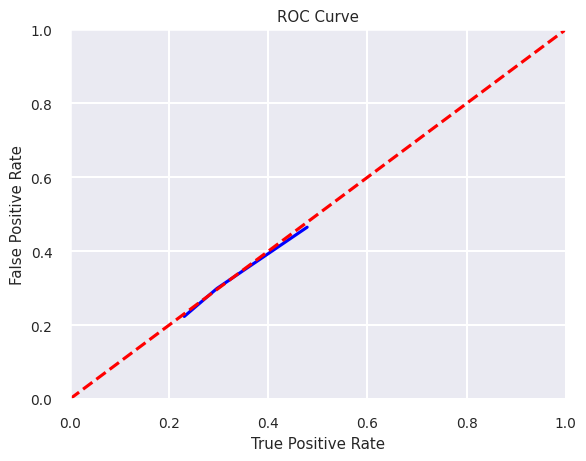

In [30]:
# ROC Curve
FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix) #false positive
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix) # false negative
TP = np.diag(conf_matrix) # true positive
TN = conf_matrix.sum() - (FP + FN + TP) # True negative

TPR = TP/(TP+FN) # true positive rate
FPR = FP/(FP+TN) # false positive rate

plt.plot(FPR,TPR,'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

## Obtain predictions

In [31]:
final_test_preds = []

if max_result_nn == 'lstm':
    final_test_preds = test_preds['lstm']
    print('lstm best.')
elif max_result_nn == 'rnn':
    final_test_preds = test_preds['rnn']
    print('rnn best.')
elif max_result_nn == 'gru':
    final_test_preds = test_preds['gru']
    print('gru best.')
elif max_result_nn == 'skip':
    final_test_preds = test_preds['skip']
    print('skip connections best.')
elif max_result_nn == 'grad_clip':
    final_test_preds = test_preds['grad_clip']
    print('gradient clipping best.')
elif max_result_nn == 'attention':
    final_test_preds = test_preds['attention']
    print('attention mechanism best.')

gru best.


## Output file

In [32]:
import csv

with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    
    writer.writerow(["Id","Predicted"])
    for i in range(0,10470):
        writer.writerow([i+1,final_test_preds[i]])  
    
    
print("CSV file writing complete.")

CSV file writing complete.
